# Text Analysis


## Question 
##### Compare the use of clickbait titles between democrats and republicans in the dataset. How many times do democrats refer to an article with a clickbait title and how many times do republicans do? Inspect the titles in the dataset that were classified as clickbait and try to explain the results.


American electoral politics has been dominated by two major political parties since shortly after the founding of the republic. Since the 1850s, they have been the Democratic Party and the Republican Party. Since the last major party realignment in the mid-20th century, the Democratic Party has been the center-left and liberal party, and the Republican Party has been the center-right and conservative party.

Source-Wikipedia

Clickbait refers to an article headline whose purpose is to use sensationalist language to lure in a viewer to click through to a certain webpage. That webpage typically generates ad revenue on the user's clicks or monitizes the user's activity data. The clickbait article itself is not written with journalistic integrity, research or really any deeper or practical meaning - it is simply a vehicle to grab clicks and activity.Here in this assignment we are going to compare use of clickbait titles between democrats and republics.



#### Text Exploration

In [2]:
# Import all libraries required for the Assignment
import pickle
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
#import the dataset . Save framing.p in the same folder as the notebook
framing= pd.read_pickle('framing.p')

In [4]:
#getting glimpse of the dataset
print(framing.shape)
framing.head(2)

(23448, 13)


,tweet_id,date,user,party,state,chamber,tweet,news_mention,url_reference,netloc,title,description,label
0,1325914751495499776,2020-11-09 21:34:45,SenShelby,R,Alabama,Senator,ICYMI – @BusinessInsider declared #Huntsville ...,businessinsider,https://www.businessinsider.com/personal-finan...,www.businessinsider.com,The 10 best US cities to move to if you want t...,The best US cities to move to if you want to s...,
1,1294021087118987264,2020-08-13 21:20:43,SenShelby,R,Alabama,Senator,Great news! Today @mazda_toyota announced an a...,,https://pressroom.toyota.com/mazda-and-toyota-...,pressroom.toyota.com,Mazda and Toyota Further Commitment to U.S. Ma...,"HUNTSVILLE, Ala., (Aug. 13, 2020) – Today, Maz...",


In [10]:
# Check Missing values
# Data seems fine
framing.isna().sum()

tweet_id         0
date             0
user             0
party            0
state            0
chamber          0
tweet            0
news_mention     0
url_reference    0
netloc           0
title            0
description      0
label            0
dtype: int64

#### Text Preprocessing

In [11]:
## We need to process title column and then predict if it is a Clickbait title or not
## Let's remove whitespaces from the column, they are of no use
framing.title = framing.title.str.strip()
# Check if any rows had just empty spaces as strings
print(len(framing[(framing.title.astype(str).str.len()==0)]))

## seems like we have 1000+ rows with no data
## Let's physically verify
framing[(framing.title.astype(str).str.len()==0)].head(2)

0


,tweet_id,date,user,party,state,chamber,tweet,news_mention,url_reference,netloc,title,description,label


In [12]:
# Let's filter out all rows where length of string is zero
framing = framing[(framing.title.astype(str).str.len()!=0)]

# Check shape of the new df
framing.shape

(22355, 13)

#### Text Classification

We use text classification when we have some texts and we want to assign labels from a pre-defined set of labels to these texts.We are going the use a dataset of 16.086 article titles that are  already either labelled as clickbait (1) or not clickbait (0). We can load the dataset from the following url:



In [ ]:
# Clickbait model as enumerated in the Data Mining Manual
DATASET_URL = 'https://gist.githubusercontent.com/amitness/0a2ddbcb61c34eab04bad5a17fd8c86b/raw/66ad13dfac4bd1201e09726677dd8ba8048bb8af/clickbait.csv'
data = pd.read_csv(DATASET_URL)

X = list(data.title.values)
y = list(data.label.values)
labels = ['not clickbait', 'clickbait']


# Train the logistic regression model on entire data
processed_texts = [text for text in nlp.pipe(X, disable=["ner", "parser"])]
tokenized_texts = [[word.text.lower() for word in text if not word.is_punct] for text in processed_texts]

cv_spacy = CountVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x)

X_train_spacy = cv_spacy.fit_transform(tokenized_texts)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train_spacy, y)

 Experimented with removing Stop words also from the tokens,Accuracy of the classifier went down, seems like stop words also form an important part of prediction accuracy
Keeping stopwords, removing punctuations

In [ ]:
# Make BOW for the title strings
final_df = framing[(framing.party == 'D')|(framing.party == 'R')]

# Make BOW for the title strings
X_test_str = list(final_df.title.values)

processed_texts_test = [text for text in nlp.pipe(X_test_str, disable=["ner", "parser"])]
tokenized_texts_test = [[word.text.lower() for word in text if not word.is_punct] for text in processed_texts_test]

X_test_spacy = cv_spacy.transform(tokenized_texts_test)

final_df['clickbait'] = lr.predict(X_test_spacy)

In [ ]:
# Let's see few rows of the prediction created
final_df.head()

In [11]:
# Creating aggregate numbers

df1 = final_df.groupby('party')['clickbait'].sum().to_frame().reset_index()
df1 = df1.rename(columns={"party": "party", "clickbait": "tot_resp"})

df2 = final_df.party.value_counts().to_frame().reset_index()
df2 = df2.rename(columns={"index": "party", "party": "tot_mem"})

final = df1.merge(df2, on='party')

final['pct_resp'] = round(final.tot_resp / final.tot_mem, 4) * 100

print(final)

  party  tot_resp  tot_mem  pct_resp
0     D      2554    14988     17.04
1     R       950     7260     13.09


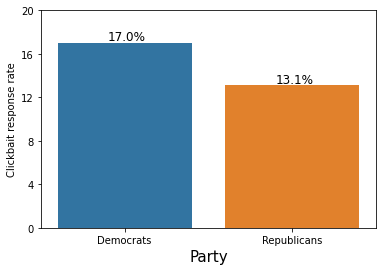

<Figure size 432x288 with 0 Axes>

In [12]:
#lets plot to look at the results better
ax = sns.barplot(x="party", y="pct_resp", data=final)
positions = (0, 1)
labels = ("Democrats", "Republicans")
plt.xticks(positions, labels)
plt.xlabel('Party', fontsize=15)
plt.ylabel('Clickbait response rate', fontsize=10)
plt.yticks([0,4,8,12,16,20])

# Add y values or response rates as the labels
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2. - 0.1, p.get_height()+0.2), size = 12)

plt.show()
plt.savefig('Clickbait_parties.png')

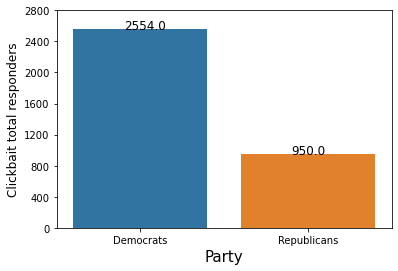

<Figure size 432x288 with 0 Axes>

In [13]:
ax = sns.barplot(x="party", y="tot_resp", data=final)
positions = (0, 1)
labels = ("Democrats", "Republicans")
plt.xticks(positions, labels)
plt.xlabel('Party', fontsize=15)
plt.ylabel('Clickbait total responders', fontsize=12)
plt.yticks([0,400,800,1200,1600,2000,2400,2800])

# Add y values or response rates as the labels
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2. - 0.1, p.get_height()+0.2), size = 12)

plt.show()
plt.savefig('Clickbait_parties_total.png')

### Analysis of Titles across different parties:
#### To make the analysis interesting I have taken Congressional districts / states which were Red / Blue as per 2016 election results. Then I have mapped these areas and tried to create analysis across 4 combinations;
1)Clickbait titles in Republican (Red) areas for Democrats

2)Clickbait titles in Democrat (Blue) areas for Democrats

3)Clickbait titles in Democrat (Blue) areas for Republicans

4)Clickbait titles in Republican (Red) areas for Republicans

In [14]:
# Create two lists of Red and Blue states as per 2016 election results
# https://en.wikipedia.org/wiki/2016_United_States_presidential_election Source: NYT

Red = ['Alabama','Alabama 1st District', 'Alabama 2nd District', 'Alabama 3rd District','Alabama 4th District',
       'Alabama 5th District', 'Alabama 6th District','Alabama 7th District', 'Alaska','Alaska At-Large','Arizona',
       'Arizona 1st District', 'Arizona 2nd District','Arizona 3rd District', 'Arizona 4th District', 'Arizona 5th District',
       'Arizona 6th District','Arizona 7th District', 'Arizona 8th District', 'Arizona 9th District', 'Arkansas', 
       'Arkansas 1st District','Arkansas 2nd District', 'Arkansas 3rd District', 'Arkansas 4th District', 'Florida',
       'Florida 1st District', 'Florida 2nd District', 'Florida 3rd District', 'Florida 4th District', 'Florida 5th District', 
       'Florida 6th District', 'Florida 7th District','Florida 8th District', 'Florida 9th District', 'Florida 10th District',
       'Florida 11th District','Florida 12th District', 'Florida 13th District', 'Florida 14th District', 'Florida 15th District',
       'Florida 16th District', 'Florida 17th District','Florida 18th District', 'Florida 20th District', 'Florida 21st District',
       'Florida 22nd District','Florida 23rd District', 'Florida 24th District', 'Florida 25th District', 'Florida 26th District',
       'Florida 27th District', 'Georgia', 'Georgia 1st District', 'Georgia 2nd District', 'Georgia 4th District',
       'Georgia 6th District', 'Georgia 7th District', 'Georgia 8th District', 'Georgia 9th District', 'Georgia 10th District', 
       'Georgia 11th District', 'Georgia 12th District', 'Georgia 13th District', 'Georgia 14th District', 'Idaho', 
       'Idaho 1st District', 'Idaho 2nd District','Indiana', 'Indiana 2nd District', 'Indiana 3rd District', 'Indiana 4th District', 
       'Indiana 5th District', 'Indiana 6th District', 'Indiana 7th District', 'Indiana 8th District', 'Iowa', 'Iowa 1st District',
       'Iowa 2nd District', 'Iowa 3rd District', 'Iowa 4th District', 'Kansas', 'Kansas 1st District', 'Kansas 2nd District',
       'Kansas 3rd District', 'Kansas 4th District', 'Kentucky', 'Kentucky 1st District','Kentucky 2nd District',
       'Kentucky 3rd District','Kentucky 4th District', 'Utah 1st District','Kentucky 6th District','Louisiana',
       'Louisiana 1st District', 'Louisiana 2nd District', 'Louisiana 4th District', 'Louisiana 5th District', 
       'Louisiana 6th District', 'Maine 2nd District', 'Michigan', 'Michigan 1st District', 'Michigan 2nd District',
       'Michigan 5th District', 'Michigan 6th District', 'Michigan 7th District', 'Michigan 8th District', 'Michigan 9th District',
       'Michigan 11th District', 'Michigan 12th District', 'Michigan 13th District', 'Michigan 14th District', 'Mississippi', 
       'Mississippi 1st District', 'Mississippi 2nd District', 'Mississippi 3rd District', 'Mississippi 4th District', 'Missouri', 
       'Missouri 1st District', 'Missouri 2nd District', 'Missouri 3rd District', 'Missouri 4th District', 'Missouri 5th District',
       'Missouri 6th District', 'Missouri 7th District', 'Missouri 8th District', 'Montana', 'Nebraska', 'Nebraska 2nd District', 
       'North Carolina', 'North Carolina 1st District', 'North Carolina 3rd District', 'North Carolina 4th District', 
       'North Carolina 5th District', 'North Carolina 6th District', 'North Carolina 7th District', 'North Carolina 8th District',
       'North Carolina 9th District', 'North Carolina 10th District', 'North Carolina 12th District', 
       'North Carolina 13th District', 'North Dakota', 'North Dakota At-Large', 'Northern Mariana Islands At-Large', 'Ohio',
       'Ohio 1st District', 'Ohio 2nd District', 'Ohio 3rd District', 'Ohio 4th District', 'Ohio 5th District', 
       'Ohio 6th District', 'Ohio 7th District', 'Ohio 8th District', 'Ohio 9th District', 'Ohio 10th District', 
       'Ohio 11th District', 'Ohio 12th District', 'Ohio 13th District', 'Ohio 14th District', 'Ohio 15th District', 
       'Ohio 16th District', 'Oklahoma', 'Oklahoma 1st District', 'Oklahoma 2nd District', 'Oklahoma 3rd District', 
       'Oklahoma 4th District', 'Oklahoma 5th District', 'Pennsylvania', 'Pennsylvania 1st District', 'Pennsylvania 2nd District',
       'Pennsylvania 3rd District', 'Pennsylvania 4th District', 'Pennsylvania 5th District', 'Pennsylvania 6th District', 
       'Pennsylvania 7th District', 'Pennsylvania 8th District', 'Pennsylvania 9th District', 'Pennsylvania 10th District', 
       'Pennsylvania 13th District', 'Pennsylvania 14th District', 'Pennsylvania 15th District', 'Pennsylvania 16th District',
       'Pennsylvania 17th District', 'Pennsylvania 18th District', 'South Carolina', 'South Carolina 1st District', 
       'South Carolina 2nd District', 'South Carolina 3rd District', 'South Carolina 4th District',
       'South Carolina 5th District', 'South Carolina 6th District', 'South Carolina 7th District', 'South Dakota',
       'South Dakota At-Large', 'Tennessee', 'Tennessee 1st District', 'Tennessee 2nd District', 'Tennessee 3rd District',
       'Tennessee 5th District', 'Tennessee 6th District', 'Tennessee 7th District', 'Tennessee 9th District', 'Texas', 
       'Texas 1st District', 'Texas 2nd District', 'Texas 3rd District', 'Texas 5th District', 'Texas 6th District', 
       'Texas 7th District', 'Texas 8th District', 'Texas 9th District', 'Texas 10th District', 'Texas 11th District', 
       'Texas 12th District', 'Texas 13th District', 'Texas 14th District', 'Texas 15th District', 'Texas 16th District', 
       'Texas 17th District', 'Texas 18th District', 'Texas 19th District', 'Texas 20th District', 'Texas 21st District', 
       'Texas 22nd District', 'Texas 23rd District', 'Texas 25th District', 'Texas 26th District', 'Texas 27th District', 
       'Texas 28th District', 'Texas 29th District', 'Texas 30th District', 'Texas 31st District', 'Texas 32nd District', 
       'Texas 33rd District', 'Texas 34th District', 'Texas 35th District', 'Texas 36th District', 'Utah', 'Utah 2nd District',
       'Utah 3rd District', 'Utah 4th District', 'West Virginia', 'West Virginia 1st District', 'West Virginia 2nd District',
       'West Virginia 3rd District', 'Wisconsin', 'Wisconsin 1st District', 'Wisconsin 2nd District', 'Wisconsin 3rd District',
       'Wisconsin 4th District', 'Wisconsin 6th District', 'Wisconsin 7th District', 'Wisconsin 8th District', 'Wyoming',
       'Wyoming At-Large']

Blue = ['California', 'California 1st District','California 2nd District', 'California 3rd District', 'California 4th District',
        'California 5th District','California 6th District', 'California 7th District', 'California 9th District', 
        'California 10th District','California 11th District', 'California 12th District', 'California 13th District',
        'California 14th District','California 15th District', 'California 16th District', 'California 18th District', 
        'California 19th District','California 20th District', 'California 21st District', 'California 22nd District', 
        'California 23rd District','California 24th District', 'California 25th District', 'California 26th District', 
        'California 27th District','California 28th District', 'California 29th District', 'California 30th District', 
        'California 31st District','California 32nd District', 'California 33rd District', 'California 34th District',
        'California 35th District','California 36th District', 'California 37th District', 'California 38th District',
        'California 39th District','California 40th District', 'California 41st District', 'California 42nd District', 
        'California 43rd District','California 44th District', 'California 45th District', 'California 46th Division', 
        'California 47th District','California 48th District', 'California 49th District', 'California 51st District', 
        'California 52nd District','California 53rd District', 'Colorado', 'Colorado 1st District', 'Colorado 2nd District', 
        'Colorado 3rd District', 'Colorado 4th District', 'Colorado 5th District', 'Colorado 6th District', 
        'Colorado 7th District', 'Connecticut','Connecticut 1st District', 'Connecticut 2nd District', 
        'Connecticut 3rd District', 'Connecticut 4th District','Connecticut 5th District', 'Delaware', 'Delaware At-Large', 
        'District of Columbia At-Large', 'Hawaii', 'Hawaii 1st District', 'Illinois', 'Illinois 1st District',
        'Illinois 2nd District', 'Illinois 3rd District', 'Illinois 4th District', 'Illinois 5th District', 
        'Illinois 6th District', 'Illinois 7th District', 'Illinois 8th District', 'Illinois 9th District', 
        'Illinois 10th District', 'Illinois 11th District', 'Illinois 12th District', 'Illinois 13th District', 
        'Illinois 14th District', 'Illinois 16th District', 'Illinois 17th District', 'Illinois 18th District', 'Maine',
        'Maine 1st District', 'Maryland', 'Maryland 1st District', 'Maryland 2nd District', 'Maryland 3rd District',
        'Maryland 4th District', 'Maryland 5th District', 'Maryland 6th District', 'Maryland 7th District', 
        'Maryland 8th District', 'Massachusetts', 'Massachusetts 1st District', 'Massachusetts 2nd District', 
        'Massachusetts 3rd District', 'Massachusetts 4th District', 'Massachusetts 5th District', 'Massachusetts 6th District',
        'Massachusetts 7th District', 'Massachusetts 9th District', 'Minnesota', 'Minnesota 1st District', 'Minnesota 2nd District',
        'Minnesota 3rd District', 'Minnesota 4th District', 'Minnesota 5th District', 'Minnesota 6th District',
        'Minnesota 8th District', 'Nevada', 'Nevada 1st District', 'Nevada 3rd District', 'Nevada 4th District', 'New Hampshire', 
        'New Hampshire 1st District', 'New Hampshire 2nd District', 'New Jersey', 'New Jersey 1st District',
        'New Jersey 3rd District','New Jersey 5th District', 'New Jersey 6th District', 'New Jersey 7th District', 
        'New Jersey 8th District', 'New Jersey 9th District', 'New Jersey 10th District', 'New Jersey 11th District',
        'New Jersey 12th District', 'New Mexico', 'New Mexico 1st District', 'New Mexico 2nd District', 'New Mexico 3rd District',
        'New York', 'New York 1st District', 'New York 3rd District', 'New York 4th District', 'New York 5th District',
        'New York 6th District', 'New York 7th District', 'New York 9th District', 'New York 10th District', 
        'New York 11th District', 'New York 12th District', 'New York 13th District', 'New York 14th District', 
        'New York 15th District', 'New York 16th District', 'New York 17th District', 'New York 18th District',
        'New York 19th District', 'New York 20th District', 'New York 21st District', 'New York 22nd District', 
        'New York 23rd District', 'New York 24th District', 'New York 25th District', 'New York 26th District', 'Oregon', 
        'Oregon 1st District', 'Oregon 2nd District', 'Oregon 3rd District', 'Oregon 4th District', 'Oregon 5th District',
        'Rhode Island', 'Rhode Island 1st District', 'Rhode Island 2nd District', 'Vermont At-Large', 'Virginia', 
        'Virginia 1st District', 'Virginia 2nd District', 'Virginia 3rd District', 'Virginia 4th District',
        'Virginia 5th District', 'Virginia 6th District', 'Virginia 7th District', 'Virginia 8th District', 
        'Virginia 9th District', 'Virginia 10th District', 'Virginia 11th District', 'Virgin Islands At-Large', 'Washington',
        'Washington 1st District', 'Washington 2nd District', 'Washington 3rd District', 'Washington 4th District',
        'Washington 5th District', 'Washington 6th District', 'Washington 7th District', 'Washington 8th District',
        'Washington 9th District', 'Washington 10th District']


In [15]:
import warnings
warnings.filterwarnings("ignore")

# Create column of tokenised title in final_df using earlier tokenised list
final_df['tok_title'] = tokenized_texts_test

#extracting state as first part of the state column by splitting using space delimiter
final_df['Elec_2016'] = np.where(final_df['state'].isin(Red),'Red','Blue')

In [16]:
# Create separate dataframe for democrats who responded to clickbait
dem = final_df[(final_df.clickbait == 1)&(final_df.party == 'D')]
dem = dem.loc[:,['Elec_2016','label','tok_title']]

# Create dataframe for democratic clickbait responses in states where Democrats won
dem_Blue = dem[(dem.Elec_2016 == 'Blue')]

# Create dataframe for democratic clickbait responses in states where Democrats lost
dem_Red = dem[(dem.Elec_2016 == 'Red')]

In [17]:
# Create list of stop words to remove from tokens

from collections import Counter

flatten = lambda t: [item for sublist in t for item in sublist]

stop_words = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']


Finding the Most famous topics democrats responded to in Red Areas

In [18]:

# Flatten the tokens for clickbait titles for democratic party
tokenized_texts_concat = flatten(list(dem_Red.tok_title))

tt_dem_Red = [word for word in tokenized_texts_concat if not word in stop_words]

wc_dem_Red = Counter(tt_dem_Red)
wc_dem_Red.most_common()[:20]

[('trump', 212),
 ("'s", 142),
 ('covid-19', 70),
 ('americans', 62),
 ("n't", 61),
 ('|', 59),
 ('know', 49),
 ('black', 48),
 ('coronavirus', 45),
 ('people', 43),
 ('’s', 42),
 ('need', 39),
 ('opinion', 34),
 ('vote', 32),
 ('mail', 32),
 ('2020', 31),
 ('get', 31),
 ('pandemic', 31),
 ('will', 31),
 ('hollywood', 31)]

In [31]:
# create counts of clickbait words and values
cb_Red_dem_counts = [x[1] for x in wc_dem_Red.most_common(20)]
cb_Red_dem_words = [x[0] for x in wc_dem_Red.most_common(20)]


In [32]:
# Getting data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
clickbait_dictionary_Red_dem = dict(zip(cb_Red_dem_words, cb_Red_dem_counts))


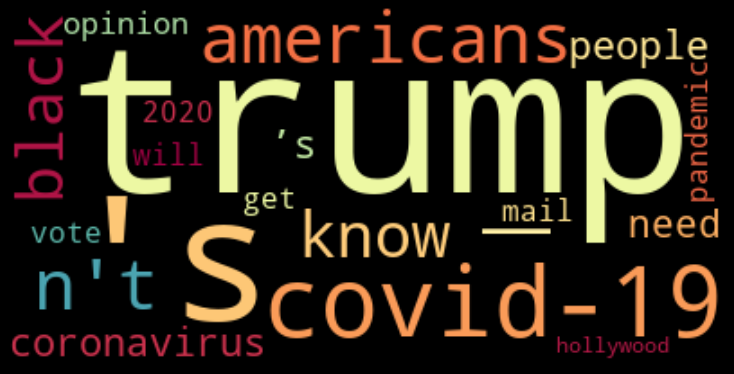

In [36]:
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary_Red_dem)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('clickbait_Red_dem')

plt.show()

#### Conclusion
In Red areas democrats are responding to corona virus related topic
Interestingly trump is also a key word here
Democrats are promoting Mail-vote as that is also a key term in Red areas

Finding the Most famous topics democrats responded to in Blue Areas

In [34]:
# Flatten the tokens for clickbait titles for democratic party
tokenized_texts_concat = flatten(list(dem_Blue.tok_title))

tt_dem_Blue = [word for word in tokenized_texts_concat if not word in stop_words]

wc_dem_Blue = Counter(tt_dem_Blue)
wc_dem_Blue.most_common()[:20]



[('trump', 437),
 ("'s", 280),
 ('|', 165),
 ("n't", 130),
 ('americans', 124),
 ('’s', 100),
 ('women', 90),
 ('coronavirus', 82),
 ('black', 81),
 ('ca', 81),
 ('covid-19', 79),
 ('new', 76),
 ('just', 73),
 ('war', 73),
 ('opinion', 72),
 ('died', 72),
 ('administration', 71),
 ('kids', 70),
 ('will', 69),
 ('vote', 69)]

In [38]:
# create counts of clickbait words and values
cb_Blue_dem_counts = [x[1] for x in wc_dem_Blue.most_common(20)]
cb_Blue_dem_words = [x[0] for x in wc_dem_Blue.most_common(20)]
clickbait_dictionary_Blue_dem = dict(zip(cb_Blue_dem_words, cb_Blue_dem_counts))


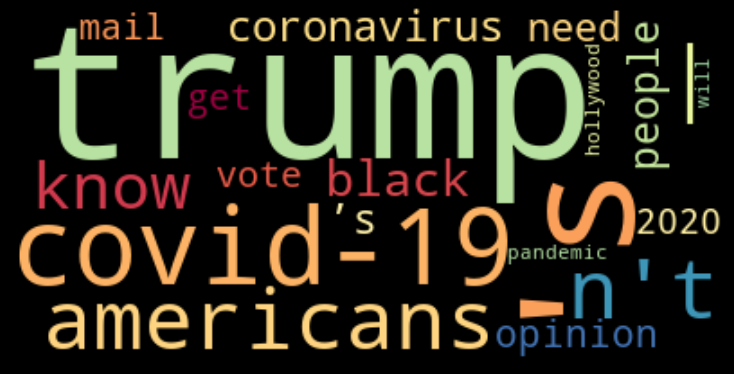

In [39]:
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('clickbait_wc_Blue_dem')

plt.show()

#### Conclusion
 In Blue areas democrats unique terms for clickbait reponse are: Black, Women, Coronavirus, Died, War, Kids, Just
 These are the themes which are closely resonating with Black Lives matter protests
 They are also targeting the Democrat voters which are African Americans and Women

In [47]:
# Create separate dataframe for democrats who responded to clickbait
rep = final_df[(final_df.clickbait == 1)&(final_df.party == 'R')]
rep = rep.loc[:,['Elec_2016','label','tok_title']]

# Create dataframe for democratic clickbait responses in states where Democrats won
rep_Blue = rep[(rep.Elec_2016 == 'Blue')]

# Create dataframe for democratic clickbait responses in states where Democrats lost
rep_Red = rep[(rep.Elec_2016 == 'Red')]

Finding the Most famous topics democrats responded to in Blue Areas

In [48]:
# Flatten the tokens for clickbait titles for democratic party
tokenized_texts_concat = flatten(list(rep_Blue.tok_title))

tt_rep_Blue = [word for word in tokenized_texts_concat if not word in stop_words]

wc_rep_Blue = Counter(tt_rep_Blue)
wc_rep_Blue.most_common()[:20]

[('|', 41),
 ("'s", 34),
 ('mike', 25),
 ('garcia', 25),
 ('’s', 21),
 ('get', 17),
 ('congress', 17),
 ('america', 15),
 ('vote', 15),
 ('rep.', 12),
 ('time', 10),
 ('people', 10),
 ('china', 10),
 ('house', 9),
 ('mccarthy', 9),
 ('national', 9),
 ('republicans', 9),
 ('vaccine', 9),
 ('kevin', 8),
 ('tax', 8)]

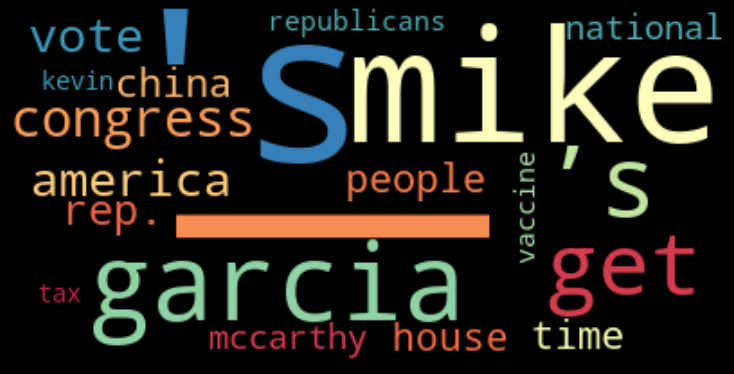

In [50]:
# create counts of clickbait words and values
wc_blue_rep_counts = [x[1] for x in wc_rep_Blue.most_common(20)]
wc_blue_rep_words = [x[0] for x in wc_rep_Blue.most_common(20)]
clickbait_dictionary_Blue_rep = dict(zip(wc_blue_rep_words, wc_blue_rep_counts))
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary_Blue_rep)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('clickbait_wc_blue_rep')

plt.show()

#### Conclusion
 In Blue areas republicans unique terms for clickbait reponse are: Vaccine, Mike Garcia (Republican Senator), China, Tax
 Republicans are trying to clickbait / create discussions around role of china in spreading virus
 Also focussing on upcoming vaccine to tackle virus spread
 Republicans are also focussing on words: House, Congress in Blue areas for clickbait

Finding the  Most famous topics democrats responded to in Blue Areas

In [51]:

# Flatten the tokens for clickbait titles for democratic party
tokenized_texts_concat = flatten(list(rep_Red.tok_title))

tt_rep_Red = [word for word in tokenized_texts_concat if not word in stop_words]

wc_rep_Red = Counter(tt_rep_Red)
wc_rep_Red.most_common()[:20]



[("'s", 192),
 ('|', 148),
 ('trump', 128),
 ('’s', 76),
 ('biden', 68),
 ('will', 61),
 ('america', 51),
 ('cruz', 51),
 ('rep.', 44),
 ("n't", 42),
 ('get', 40),
 ('barrett', 39),
 ('sen.', 38),
 ('coronavirus', 37),
 ('national', 36),
 ('vaccine', 35),
 ('people', 35),
 ('review', 34),
 ('twitter', 32),
 ('ted', 32)]

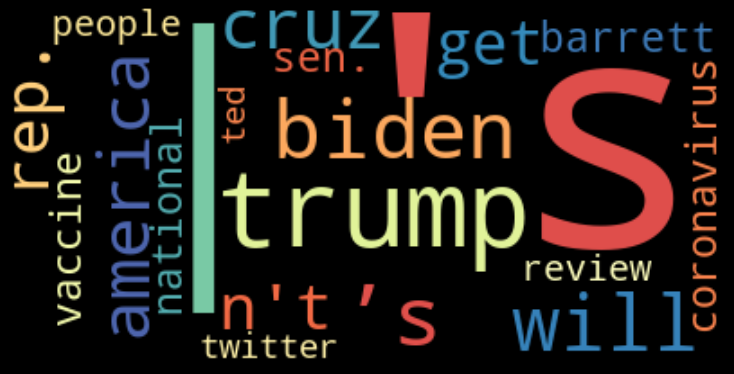

In [53]:
# create counts of clickbait words and values
wc_red_rep_counts = [x[1] for x in wc_rep_Red.most_common(20)]
wc_red_rep_words = [x[0] for x in wc_rep_Red.most_common(20)]
clickbait_dictionary_Red_rep = dict(zip(wc_red_rep_words, wc_red_rep_counts))
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary_Red_rep)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('clickbait_wc_Red_rep')

plt.show()

####  Conclusion
 In Red areas Republicans unique terms for clickbait reponse are: Trump & Ted Cruz (names of two top republicans)
 They are also using Biden (possibly its link with negative sentiment) as clickbait topic
 Twitter the medium of choice for communication for Donald trump is also a top word in getting clickbaits
 In Red areas Amy Coney 'Barett' the new appointee to Supreme court is also a top clickbait topic